<a href="https://githubtocolab.com/Hitsh987/projet_IARN/blob/master/endoscopy_multiClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Classification of Anomalies in Gastrointestinal Tract through Endoscopic Imagery with Deep Learning


### we used opencv for preproccesing the image dataset

### we used tensorflow and keras libarary for machine learning stuff


In [21]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# importing other required libraries
from keras.models import Sequential, load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau

# from keras.applications import VGG19 #For Transfer Learning
from tensorflow.keras.applications import VGG19  # For Transfer Learning
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator


# setup the dataset


In [22]:
# dataset_dir = "/content/kvasir-dataset"
# dataset_dir = "../input/kvasir-dataset/kvasir-dataset"
# dataset_dir = "./kvasir-dataset"


In [23]:
def in_colab():
    try:
        import google.colab

        IN_COLAB = True
    except:
        IN_COLAB = False
    return IN_COLAB


def in_kaggle():
    import os
    return os.path.isdir("../input") and os.path.isdir("/kaggle/working")
    

In [24]:
def get_dataset_from_drive():
    # mount google-drive to colab
    from google.colab import drive
    drive.mount('/content/drive')
    
    # unzip dataset to /content/kvasir_dataset
    path_to_directory = "/content/"
    path_to_file = "/content/drive/MyDrive/kvasir_dataset.zip"
    !unzip $path_to_file -d $path_to_directory
    
    
def download_dataset(URL, dataset_name):
    import tensorflow as tf
    import os
    
    path_to_zip = tf.keras.utils.get_file(
        f"{dataset_name}.zip", origin=URL, extract=True
    )
    path = os.path.join(os.path.dirname(path_to_zip), dataset_name)
    return path

In [25]:
dataset_name = "kvasir-dataset"
URL = f"https://datasets.simula.no/downloads/kvasir/kvasir-dataset.zip"

In [26]:
if in_colab():
    if not os.path.isdir("/root/.keras/datasets/kvasir-dataset"):
        dataset_dir = download_dataset(URL, "kvasir-dataset")
    
elif in_kaggle():
    dataset_dir = "../input/kvasir-dataset/kvasir-dataset"
    
else:
    dataset_dir = "./kvasir-dataset" 

In [27]:
dataset_dir

'./kvasir-dataset'

### define the categories the dataset categories(class)


In [4]:
import pandas as pd
import glob


def get_dataCategories(dataset_dir):
    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])


categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"categorie": categories, "numbre of files": nbr_files})

print("number of categories: ", len(categories))
df


number of categories:  8


,categorie,numbre of files
0,dyed-lifted-polyps,500
1,dyed-resection-margins,500
2,esophagitis,500
3,normal-cecum,500
4,normal-pylorus,500
5,normal-z-line,500
6,polyps,500
7,ulcerative-colitis,500


### using the opencv, we read images from dataset directory and resize images to 100\*100

### then insert:

- the resized image in `X`
- class lable in `y`


In [5]:
# load dataset
def create_dataset(datadir, categories, img_wid, img_high):
    X = []
    y = []

    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                X.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                pass

    y = np.array(y)
    X = np.array(X).reshape(y.shape[0], img_wid, img_wid, 3)
    return X, y


img_wid, img_high = 100, 100
X, y = create_dataset(dataset_dir, categories, img_wid, img_high)


print(f"X: {X.shape}")
print(f"y: {y.shape}")


data: (4000, 100, 100, 3)
X: (4000, 100, 100, 3)
y: (4000,)


### Show random image for each category


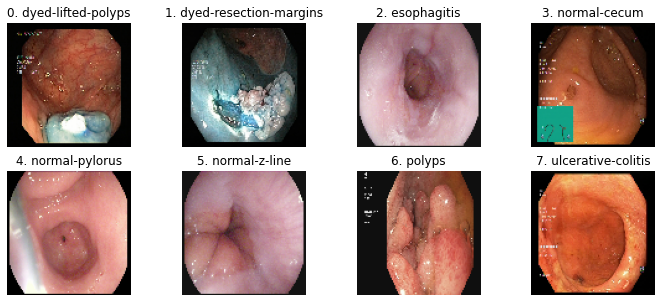

In [6]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    # plt.imshow(X[idx][:,:,::-1])
    plt.imshow(X[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()


### partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing


In [7]:
Y = np.reshape(y, (len(y), 1))

# split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, random_state=42
)
print(f"X_train: {X_train.shape}")
print(f"t_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


X_train: (3200, 100, 100, 3)
t_train: (3200, 1)
X_test: (800, 100, 100, 3)
y_test: (800, 1)


In [8]:
# defining training and test sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
x_test = X_test

# Dimension of the dataset
print("x_train, y_train: ", (x_train.shape, y_train.shape))
print("x_val, y_val: ", (x_val.shape, y_val.shape))
print("x_test, y_test: ", (x_test.shape, y_test.shape))


x_train, y_train:  ((2240, 100, 100, 3), (2240, 1))
x_val, y_val:  ((960, 100, 100, 3), (960, 1))
x_test, y_test:  ((800, 100, 100, 3), (800, 1))


In [9]:
# One Hot Encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Verifying the dimension after one hot encoding
print((x_train.shape, y_train.shape))
print((x_val.shape, y_val.shape))
print((x_test.shape, y_test.shape))


((2240, 100, 100, 3), (2240, 8))
((960, 100, 100, 3), (960, 8))
((800, 100, 100, 3), (800, 8))


In [10]:
# Image Data Augmentation
train_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

val_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

test_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

# Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)


In [11]:
# Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor="val_acc", factor=0.01, patience=3, min_lr=1e-5)


In [12]:
# Defining the VGG Convolutional Neural Net
if os.path.isfile("./saved_model/vgg19_model.h5"):
    base_model = load_model("./saved_model/vgg19_model.h5")
else:
    base_model = VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(100, 100, 3),
        classes=y_train.shape[1],
    )
    # save model
    base_model.save("./saved_model/vgg19_model.h5")


# Adding the final layers to the above base models where the actual classification is done in the dense layers
model = Sequential()
model.add(base_model)
model.add(Flatten())

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024, activation=("relu"), input_dim=512))
model.add(Dense(512, activation=("relu")))
model.add(Dense(256, activation=("relu")))
model.add(Dropout(0.3))
model.add(Dense(128, activation=("relu")))
# model.add(Dropout(.2))
model.add(Dense(y_train.shape[1], activation=("softmax")))

# Checking the final model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [14]:
# Initializing the hyperparameters
batch_size = 100
epochs = 50
learn_rate = 0.001
sgd = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)
adam = Adam(
    learning_rate=learn_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=None,
    decay=0.0,
    amsgrad=False,
)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])


In [15]:
# Training the model
if os.path.isfile("./saved_model/model.h5"):
    model = load_model("./saved_model/model.h5")

    if os.path.isfile("./saved_model/model_history.npy"):
        history = np.load("./saved_model/model_history.npy", allow_pickle="TRUE").item()
    else:
        history = None
else:
    history = model.fit(
        # train_generator.flow(x_train, y_train, batch_size= batch_size),
        x_train,
        y_train,
        epochs=epochs,
        steps_per_epoch=x_train.shape[0] // batch_size,
        validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size),
        validation_steps=250,
        callbacks=[lrr],
        verbose=1,
    )
    history = history.history

    # save model
    np.save("./saved_model/model_history.npy", history)
    model.save("./saved_model/model.h5")


In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", round(score[0], 3))
print("Test accuracy:", round(score[1], 3))


Test loss: 0.337
Test accuracy: 0.938


In [17]:
def cm_plt(ax, cm, classes, cmap, title, normalize):

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax


# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.Blues):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )


In [18]:
# Making prediction
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)


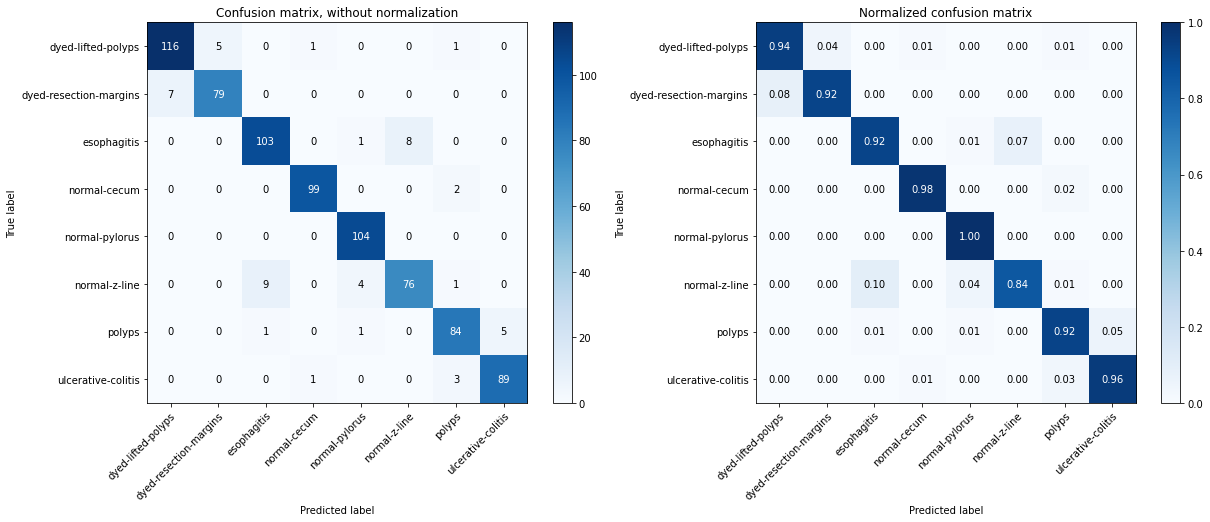

In [19]:
# get confusion matrix
confuision_mat = confusion_matrix(y_true, y_pred)
# plot confusion_mat
plt_confusion_mat(confuision_mat, classes=categories, fig_size=(20, 7))


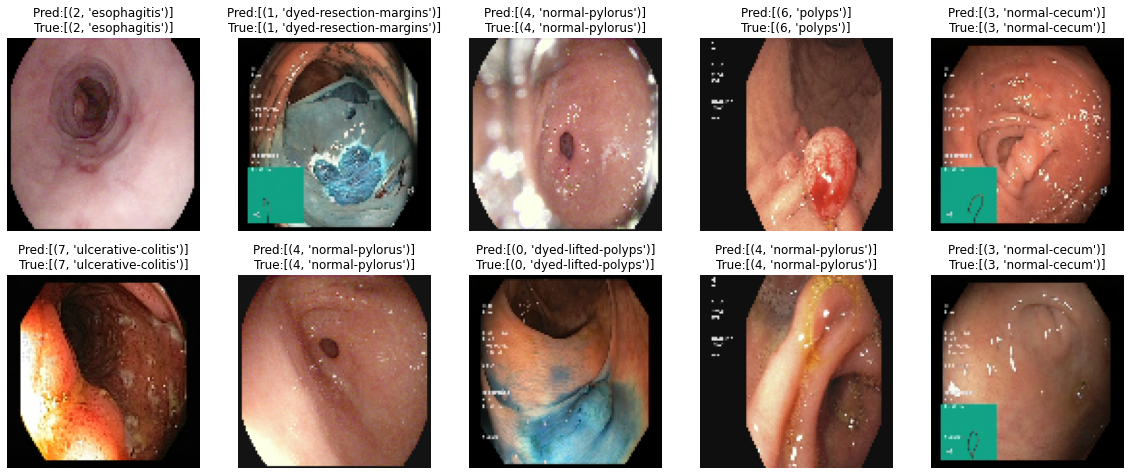

In [20]:
def predict_categorie_img(img, model, categories):
    try:
        img = img[None, :, :, :]
    except:
        raise TypeError("test image dimension != 3")
    predict = model.predict(img)
    idx_cat = np.argmax(predict, axis=1)[0]
    return idx_cat, categories[idx_cat]


plt.figure(figsize=(20, 8))
for i in range(10):
    idx = np.random.randint(len(y))
    img = X[idx]
    pred_class = predict_categorie_img(img, model, categories)
    true_class = y[idx], categories[y[idx]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img[:, :, ::-1])
    plt.title(f"Pred:[{pred_class}]\nTrue:[{true_class}]")
    plt.axis("off")
plt.show()
